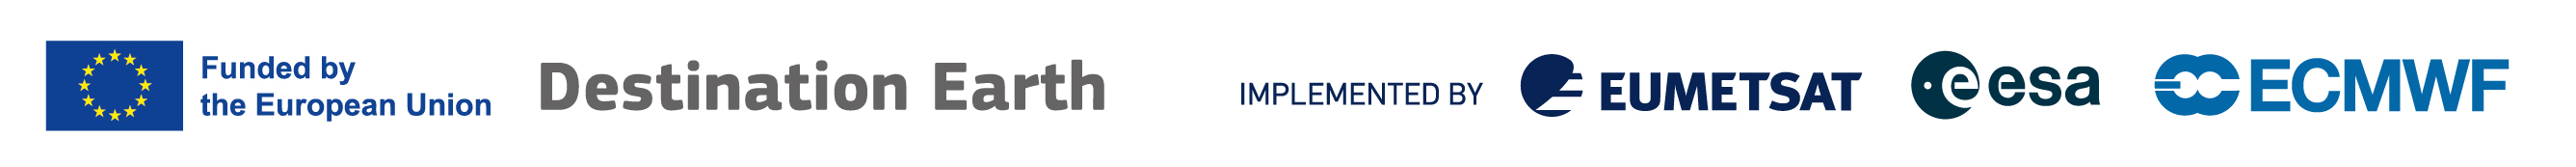

<b>Author:</b> EUMETSAT  
<b>Copyright:</b> 2024 EUMETSAT  
<b>Licence:</b> MIT   

# Example of Using HDA to Find and Download Data for Urban Area Monitoring Using Sentinel-1 Data

In this notebook, we will present a simple example of how you can access data from DEDL using HDA and what you can do with it. We will demonstrate how to utilize thresholding techniques and compare the values of VV and VH polarizations to analyze urban areas. As an illustration, we will attempt to download Sentinel-1 images containing data of the urban area of Warsaw (Poland).

# 1. Prerequiaretes

## 1.1 DestinE account

Firstly, to work with HDA we will need account on DestinE Core Service Platfrom website. You can register under this url: https://platform.destine.eu/

## 1.2 Libraries
We will use following libraries. `destinelab`, `request`, `pandas`, `rasterio`, `matplotlib` and `geopandas` are libraries that are not defaultly installed in python. If you haven't used them before, you will need to install them with either `pip` or `conda`. 

More about `pip` and `conda` environments and installation guide, you can find here:
* https://pypi.org/project/pip/
* https://conda.io/projects/conda/en/latest/user-guide/install/index.html

In [9]:
import datetime
import requests
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import requests
import zipfile
import json
import io
from rasterio.mask import mask
import os
import destinelab as da

## 1.3 Prerequiared data
Before reuqesting some data from DEDL, let's specify what data we want to obtain. We will define 3 variables:
* Start date and end date,
* Output directory,
* Geometry of interesting us area

`Start date and end date` will define our timerange in reuqest. HDA will search only for products that were obtained between those two dates.

`Output directory` will define directory for downloaded products.

`Geometry` wll define our area of interest. It will be passed as BBOX (Bounding Box), as a list of coordinates - Xmin, Ymin, Xmax, Ymax. All coordinates will be defined in EPSG:4326.

In [1]:
# Timerange of data that we want to recieve
start_date = '2023-07-01'
end_date = '2023-07-07'
# Output directory of our desired data
output_dir = 'sen_1/'
# Geometry in form of a BBOX
bbox = [20.8510, 52.0976, 21.2712, 52.3345,]

# 2. Work with HDA
HDA (Harmonized Data Access) uses STAC protocol, that allows its user access the Earth Observation data, stored in various provides. Thanks to that, HDA serves as an one stream of data, allowing for comfortable work with sattelite imagery.

# 2.1 API URLs
HDA, as all API, is build upon many endpoints. In this notebook we will use only one for collections and searching. Below there are definitions of those endpoints. We will be using `lumi` site, but you can change it to `central` ot `leonardo` if you want to.

In [2]:
COLLECTIONS_URL = 'https://hda.lumi.data.destination-earth.eu/stac/collections'
SEARCH_URL = 'https://hda.lumi.data.destination-earth.eu/stac/search'

# 2.2 Listing available collections
Firstly lets see to what collections we can get access, while using HDA.

In [5]:
def get_stac_collections(api_url):
    response = requests.get(api_url)
    if response.status_code == 200:
        stac_data = response.json()['collections']
        collections = [x['id'] for x in stac_data]
        return collections
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None
    
get_stac_collections(COLLECTIONS_URL)

['EO.CLMS.DAT.CORINE',
 'EO.CLMS.DAT.GLO.DMP300_V1',
 'EO.CLMS.DAT.GLO.FAPAR300_V1',
 'EO.CLMS.DAT.GLO.FCOVER300_V1',
 'EO.CLMS.DAT.GLO.GDMP300_V1',
 'EO.CLMS.DAT.GLO.LAI300_V1',
 'EO.CLMS.DAT.GLO.NDVI300_V1',
 'EO.CLMS.DAT.GLO.NDVI_1KM_V2',
 'EO.CLMS.DAT.SENTINEL-2.HRVPP.VI',
 'EO.DEM.DAT.COP-DEM_GLO-30-DGED',
 'EO.DEM.DAT.COP-DEM_GLO-30-DTED',
 'EO.DEM.DAT.COP-DEM_GLO-90-DGED',
 'EO.DEM.DAT.COP-DEM_GLO-90-DTED',
 'EO.ECMWF.DAT.CAMS_EUROPE_AIR_QUALITY_FORECASTS',
 'EO.ECMWF.DAT.CAMS_EUROPE_AIR_QUALITY_REANALYSES',
 'EO.ECMWF.DAT.CAMS_GLOBAL_ATMOSHERIC_COMPO_FORECAST',
 'EO.ECMWF.DAT.CAMS_GLOBAL_EMISSION_INVENTORIES',
 'EO.ECMWF.DAT.CAMS_GLOBAL_FIRE_EMISSIONS_GFAS',
 'EO.ECMWF.DAT.CAMS_GLOBAL_GREENHOUSE_GAS_REANALYSIS',
 'EO.ECMWF.DAT.CAMS_GLOBAL_GREENHOUSE_GAS_REANALYSIS_MONTHLY_AV_FIELDS',
 'EO.ECMWF.DAT.CAMS_GLOBAL_RADIATIVE_FORCING',
 'EO.ECMWF.DAT.CAMS_GLOBAL_RADIATIVE_FORCING_AUX',
 'EO.ECMWF.DAT.CAMS_GLOBAL_REANALYSIS_EAC4',
 'EO.ECMWF.DAT.CAMS_GLOBAL_REANALYSIS_EAC4_MONTHLY_AV_

As you can see, there are many dataset, that can be access using just one single tool - HDA. In this notebook we will use only Sentinel-1 (GRDH) images, so our collection will be `EO.ESA.DAT.SENTINEL-1.L1_GRD`.

In [6]:
collections = ['EO.ESA.DAT.SENTINEL-1.L1_GRD']

## 2.3 Authorization

As stated before, to use HDA you will need an account on DestinE. Using your credentials, you will be able to generate `access token`, that will be needed in upcoming requests. In listing collections' cell you didn't have to create token, because only more advanced requests (like listing, searching and downloading items) need it.

Below is cell with definition of a function to generate access token, where you need to pass your username and password as arguments.

IMPORTANT  
You need <b>.json</b> file where your credentials are stored. It should look like:  
{  
    "username": "USER",  
    "password": "PASSWORD"  
  }  
  

In [10]:
path_to_credentials = "../desp_iam.json"

with open(path_to_credentials, "r") as handler:
    credentials = json.load(handler)
    
DESP_USERNAME = credentials["username"]
DESP_PASSWORD = credentials["password"]

token = da.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = token.get_token()

# Check the status of the request
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

Response code: 200
DEDL/DESP Access Token Obtained Successfully


## 2.4 Find newest product
After defining all prerequired data and obtaining access token, we can start searching for interesting us products. To do that, we will firstly create body of a POST request with ours parameters. Then, we will send it to HDA and, if request is successful, we will read from response download link. 

In [11]:
def search_items(access_token: str, search_url: str, collection: str, 
                 bbox: list[float | int], start_date: str, end_date: str):
    body = {
        'datetime': f'{start_date}T00:00:00Z/{end_date}T23:59:59Z',
        'collections': [collection],
        'bbox': bbox
    }
    response = requests.post(search_url, json=body, headers={'Authorization': 'Bearer {}'.format(access_token)})
    if response.status_code != 200:
        print(f'Error in search request: {response.status_code} - {response.text}')
        return None
    else:
        print("Request successful! Reading data...")
        products_list = [(feature.get('assets').get('downloadLink').get('href'), feature.get('links')[0].get('title')) for feature in response.json().get('features', [])]
        return products_list

In [12]:
collections_items = []
for c in collections:
    collections_items.append(search_items(access_token, SEARCH_URL, c, bbox, start_date, end_date))

Request successful! Reading data...


## 2.5 Download founded images
After obtaining URLs for each interesting us product, we can download it with one request. Product will be downloaded compressed in zip format.

In [13]:
def hda_download(access_token: str, url: str, output: str):
    response = requests.get(url,stream=True,headers={'Authorization': 'Bearer {}'.format(access_token), 'Accept-Encoding': None})
    if response.status_code == 200:
        print('Downloading dataset...')
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            z.extractall(output)
        print('The dataset has been downloaded to: {}'.format(output))
    else:
        print('Request Unsuccessful! Error-Code: {}'.format(response.status_code))

In [14]:
for collection in collections_items:
    for item in collection:
        url = item[0]
        product_id = item[1]
        download_path = output_dir + product_id
        hda_download(access_token, url, download_path)
        break

The dataset has been downloaded to: sen_1/S1A_IW_GRDH_1SDV_20230701T044440_20230701T044505_049225_05EB41_804C


# 4. Urban areas extraction by tresholding
The analysis of Synthetic Aperture Radar (SAR) images enables the detection of variations in radar wave reflections, which is crucial for identifying urbanized areas. SAR images exhibit distinct reflection patterns that allow for the delineation of urban areas, including agglomerations and smaller urban settlements. Urbanized areas stand out in these images primarily due to the intense reflection of radar waves by man-made structures, roads, and other artificial elements of infrastructure, facilitating their clear identification contrasted with natural terrain. Such analysis of areas like the Warsaw agglomeration can serve for monitoring city growth and development, urban planning, assessment of natural and anthropogenic threats, and environmental management. The image clearly depicts the Warsaw agglomeration area, adjacent to the region between the Warsaw and Łódź agglomerations. This space is currently planned for development to connect both agglomerations. In the central part of the frame, there are plans for establishing a large airport complex.

## 4.1 Reading and preprocessing data

The first step in our analysis will be data reading. The data will be read using the rasterio library from the output folder path provided in the previous section.

In [15]:
# Function to find files containing specific substrings ("vv" and "vh") in their names
def find_files_with_names(folder_path, *names):
    vv_path = None  
    vh_path = None  
    
    # Traverse the directory tree starting at folder_path
    for root, dirs, files in os.walk(folder_path):
        if dirs:  # Check if there are subdirectories
            first_subfolder = dirs[0]
            measurement_folder = os.path.join(root, first_subfolder, "measurement")
            
            if os.path.isdir(measurement_folder):
                # Look through the files in the "measurement" folder
                for file_name in os.listdir(measurement_folder):
                    if "vv" in file_name:
                        vv_path = os.path.join(measurement_folder, file_name)
                    elif "vh" in file_name:
                        vh_path = os.path.join(measurement_folder, file_name)
                break  # Exit after finding the files
    return vv_path, vh_path

# Find the "vv" and "vh" files in the specified directory
input_file_vv, input_file_vh = find_files_with_names(output_dir, "vv", "vh")

# Open the "vv" file and read its data and profile
with rasterio.open(input_file_vv) as src_vv:
    vv_band = src_vv.read(1)
    profile_vv = src_vv.profile

# Open the "vh" file and read its data and profile
with rasterio.open(input_file_vh) as src_vh:
    vh_band = src_vh.read(1)
    profile_vh = src_vh.profile


## 4.2 Pixel value covertion to decibels
After reading the data, we can convert the pixel values to decibels. Data from Sentinel-1 is converted to the decibel scale (dB) to better visualize differences in the intensity of radar wave reflection, which aids in the analysis of urban areas due to their specific reflection characteristics.

In [16]:
def convert_to_db(image):
    # Replace zeros with a small positive value to avoid taking log of zero
    image[image == 0] = np.finfo(float).eps  

    # Calculate dB values
    image_db = 10 * np.log10(image)

    # Replace infinite values with the maximum finite value
    max_value = np.nanmax(image_db[np.isfinite(image_db)])  
    image_db[np.isinf(image_db)] = max_value  

    return image_db

vv_band_db = convert_to_db(vv_band)
vh_band_db = convert_to_db(vh_band)

/tmp/ipykernel_2710/220689011.py:6: RuntimeWarning: divide by zero encountered in log10
  image_db = 10 * np.log10(image)


## 4.3 Data analysis and tresholding

The next step involves plotting histograms of the decibel pixel values for both the VV and VH bands. These histograms provide insights into the distribution of radar reflection intensities, aiding in understanding the characteristics of the observed area. The chosen thresholds, 23.5 dB for VV and 21.5 dB for VH, are selected based on prior knowledge or analysis requirements specific to urban areas to segment regions of interest in the images. The thresholding method applied here converts pixel values above the threshold to 1 and those below to 0, aiding in the delineation of features or areas with specific radar reflection characteristics typical of urban environments.

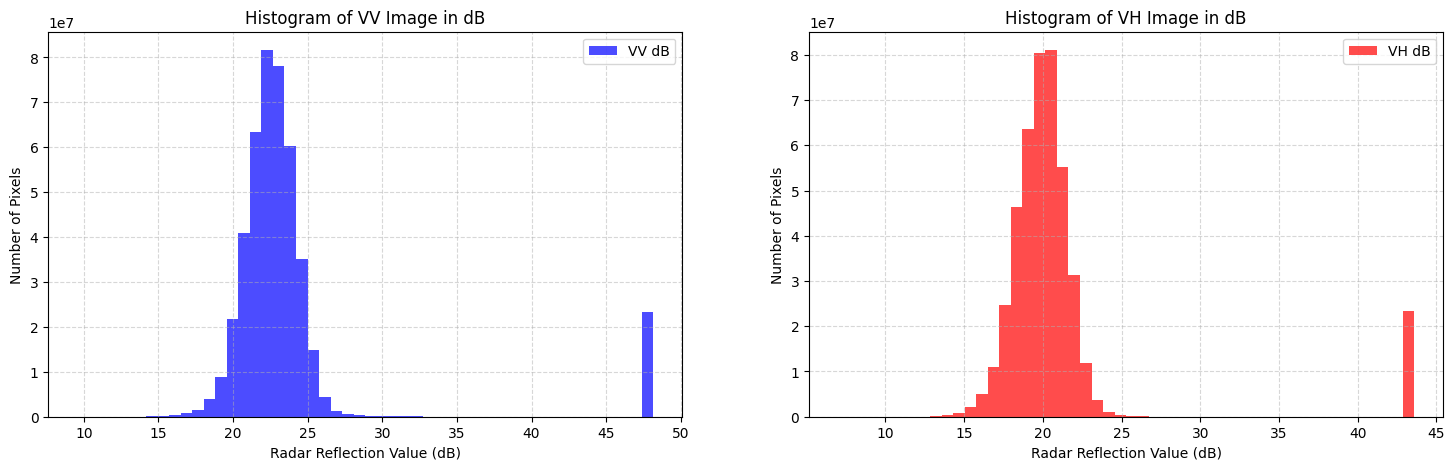

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

# Histogram of VV Image in dB
axs[0].hist(vv_band_db.flatten(), bins=50, color='blue', alpha=0.7, label='VV dB')
axs[0].set_title('Histogram of VV Image in dB')
axs[0].set_xlabel('Radar Reflection Value (dB)')
axs[0].set_ylabel('Number of Pixels')
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.5)

# Histogram of VH Image in dB
axs[1].hist(vh_band_db.flatten(), bins=50, color='red', alpha=0.7, label='VH dB')
axs[1].set_title('Histogram of VH Image in dB')
axs[1].set_xlabel('Radar Reflection Value (dB)')
axs[1].set_ylabel('Number of Pixels')
axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.5)

plt.show()

# Function to apply a threshold to an image
# Pixels greater than the threshold are set to 1, others to 0
def thresholding(image, threshold):
    return (image > threshold).astype(np.uint8)

# Define threshold values for VV and VH bands
threshold_value_vv = 23.5
threshold_value_vh = 21.5

# Apply thresholding to the VV and VH band
vv_band_threshold = thresholding(vv_band_db, threshold_value_vv)
vh_band_threshold = thresholding(vh_band_db, threshold_value_vh)

# Combine the thresholded images using a logical AND operation
# The result is 1 where both VV and VH are above their respective thresholds
combined_threshold = np.logical_and(vv_band_threshold, vh_band_threshold).astype(np.uint8)


## 4.4 Images ploting 
Next on the subplots we can visualize the differences in radio signal reflection for various polarization types. By displaying the original and decibel-transformed images for both VV and VH polarizations, we can observe distinct features and intensities in urban areas. Furthermore, by combining information from both polarizations through thresholding, we enhance our ability to mask urbanized regions, providing a more comprehensive understanding of the observed area's urban characteristics.

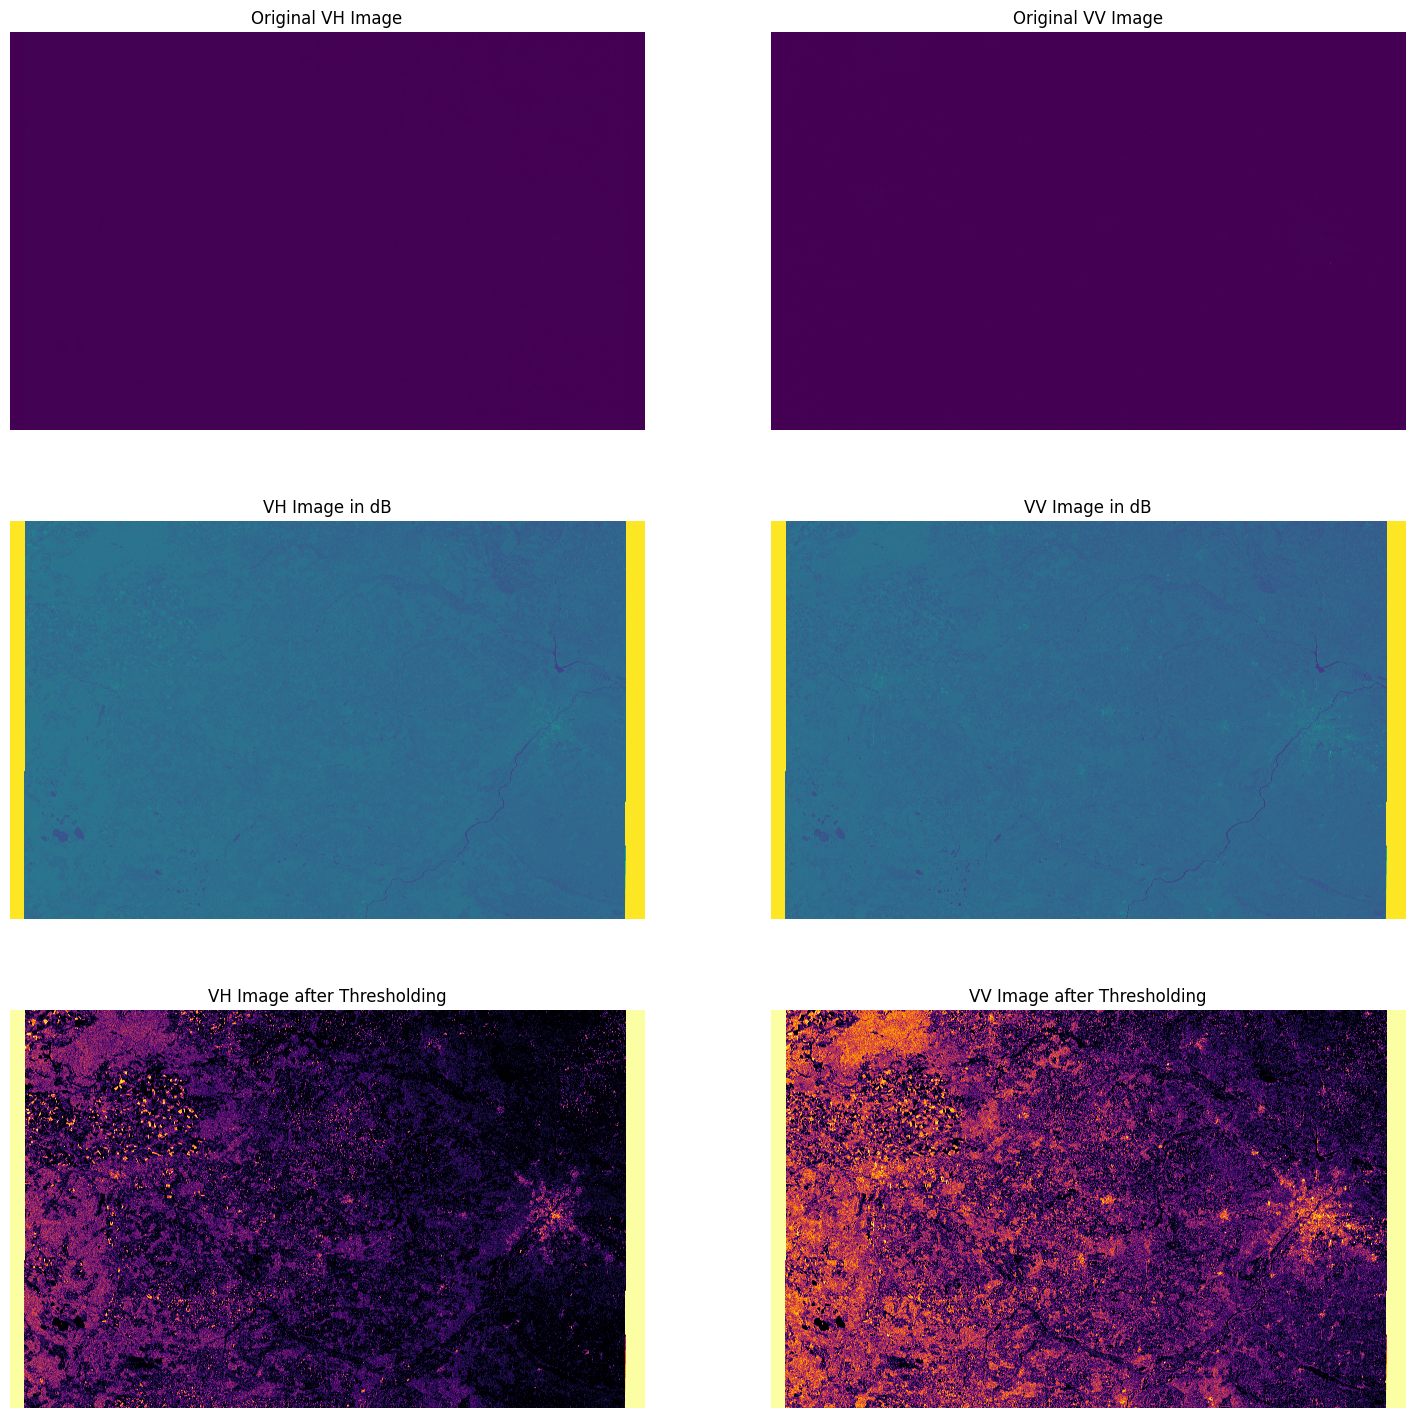

In [18]:
# Create a figure with a 3x2 grid of subplots, setting the overall figure size
fig, ax = plt.subplots(3, 2, figsize=(18, 18)) 

# Display the original VV image
ax[0, 1].imshow(vv_band, cmap='viridis')
ax[0, 1].set_title('Original VV Image')

# Display the VV image in decibels
ax[1, 1].imshow(vv_band_db, cmap='viridis')
ax[1, 1].set_title('VV Image in dB')

# Display the VV image after thresholding
ax[2, 1].imshow(vv_band_threshold, cmap='inferno')
ax[2, 1].set_title('VV Image after Thresholding')

# Display the original VH image
ax[0, 0].imshow(vh_band, cmap='viridis')
ax[0, 0].set_title('Original VH Image')

# Display the VH image in decibels
ax[1, 0].imshow(vh_band_db, cmap='viridis')
ax[1, 0].set_title('VH Image in dB')

# Display the VH image after thresholding
ax[2, 0].imshow(vh_band_threshold, cmap='inferno')
ax[2, 0].set_title('VH Image after Thresholding')

# Turn off the axes for all subplots to improve the visual presentation
for i in range(2):
    for j in range(3):
        ax[j, i].axis('off')

# Show the complete figure
plt.show()

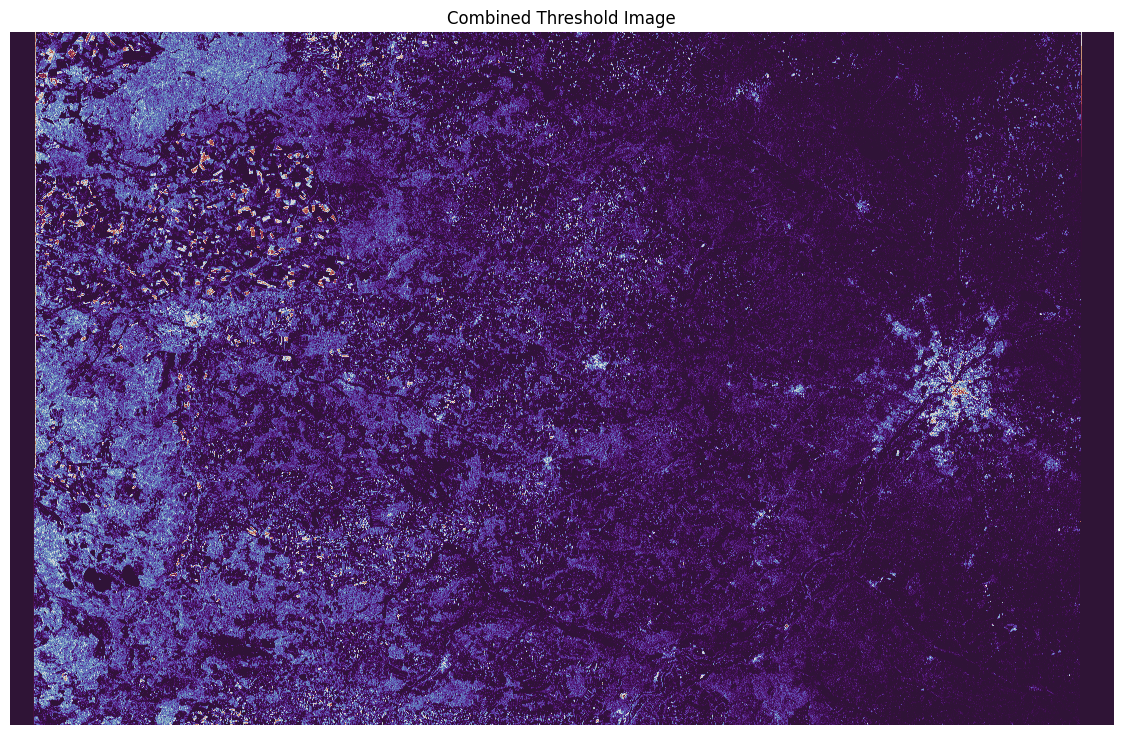

In [17]:
# Display the combined threshold image using a specific colormap
plt.figure(figsize=(18, 9))  
plt.imshow(combined_threshold, cmap='twilight_shifted')
plt.title('Combined Threshold Image')  
plt.axis('off')  
plt.show()

This method of data analysis facilitates straightforward masking of urbanized areas. In the processed image, the Warsaw agglomeration is clearly visible on the right side. A star-shaped accumulation of population is apparent in Warsaw along major transportation corridors such as railways and expressways. Smaller urban centers are visible in the image. Furthermore, it can be observed that the number of masked pixels accumulates as we approach the city center, indicating denser urban development in the downtown area compared to the suburbs.

## 4.5 Cuantitive analysis
After processing our satellite images, we can conduct quantitative analysis. The characteristics of the satellite data enable us to analyze individual pixel values, which is crucial for detailed and statistical studies. In our case, having the data thresholded and the size of each pixel being 10x10 meters, we can calculate the percentage and the adequate size of the urbanized area.

In [19]:
# Calculate the number of urban pixels by summing up the binary values in the combined threshold image
urban_pixels = np.sum(combined_threshold)

# Define the area covered by a single pixel (in square meters)
pixel_area = 10 * 10  # Assuming each pixel represents a 10m x 10m area

# Calculate the total urban area in square meters
urban_area = urban_pixels * pixel_area

# Calculate the total number of pixels in the combined threshold image
total_pixels = combined_threshold.size

# Calculate the percentage of urbanized area in the image
urban_percentage = (urban_pixels / total_pixels) * 100

# Convert urban area from square meters to hectares
urban_area_hectares = urban_area / 10_000  

# Convert total area from square meters to hectares
total_area_hectares = (total_pixels * pixel_area) / 10_000

print(f"Percentage of Urbanized Area: {urban_percentage:.2f}%")
print(f"Urbanized Area: {urban_area_hectares:.2f} ha")
print(f"Total Image Area: {total_area_hectares:.2f} ha")

Percentage of Urbanized Area: 12.60%
Urbanized Area: 557958.76 ha
Total Image Area: 4427348.42 ha


## 4.6 Results download

In [20]:
# Define output file names
output_file_db_vv = 'vv_db_urban_warsaw.tif'
output_file_db_vh = 'vh_db_urban_warsaw.tif'
output_file_threshold_combined = 'warsaw_urban_threshold_combined.tif'

# Update the data type in the profile to float32 for dB conversion
profile_vv.update(dtype=rasterio.float32)
profile_vh.update(dtype=rasterio.float32)

# Write the result data in dB to the output file
with rasterio.open(output_file_db_vv, 'w', **profile_vv) as dst:
    dst.write(vv_band_db.astype(np.float32), 1)
    
with rasterio.open(output_file_db_vh, 'w', **profile_vh) as dst:
    dst.write(vh_band_db.astype(np.float32), 1)

# Update the data type in the VV profile to uint8 for the combined thresholded image
profile_vv.update(dtype=rasterio.uint8)

# Write the combined thresholded image data to the output file
with rasterio.open(output_file_threshold_combined, 'w', **profile_vv) as dst:
    dst.write(combined_threshold, 1)

/home/patryk/miniconda3/envs/hda/lib/python3.11/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
